212039 - Muhammad Faizan

BSCS-8B

Task 1

In [ ]:
!pip install timm transformers scikit-learn

Part 1: Data Preparation and ConvNeXt Training

In [7]:
import os
import torch
import timm
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset from folder
dataset = datasets.ImageFolder(root='/content/Dataset/DataSet', transform=transform)
class_names = dataset.classes

# Split into train, val, test
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


ConvNeXt Model Setup and Training

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pretrained ConvNeXt model
model = timm.create_model('convnext_tiny', pretrained=True, num_classes=4)
model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []

for epoch in range(10):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc.append(correct / total)
    train_loss.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    correct, total, val_running_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc.append(correct / total)
    val_loss.append(val_running_loss / len(val_loader))

    print(f"Epoch {epoch+1}/10 => Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1/10 => Train Acc: 0.8381, Val Acc: 0.9333
Epoch 2/10 => Train Acc: 0.9730, Val Acc: 0.9889
Epoch 3/10 => Train Acc: 0.9865, Val Acc: 0.9926
Epoch 4/10 => Train Acc: 0.9873, Val Acc: 1.0000
Epoch 5/10 => Train Acc: 0.9778, Val Acc: 0.9852
Epoch 6/10 => Train Acc: 0.9905, Val Acc: 1.0000
Epoch 7/10 => Train Acc: 0.9865, Val Acc: 1.0000
Epoch 8/10 => Train Acc: 0.9952, Val Acc: 1.0000
Epoch 9/10 => Train Acc: 0.9992, Val Acc: 0.9963
Epoch 10/10 => Train Acc: 0.9897, Val Acc: 1.0000


Plotting Accuracy & Loss Curves

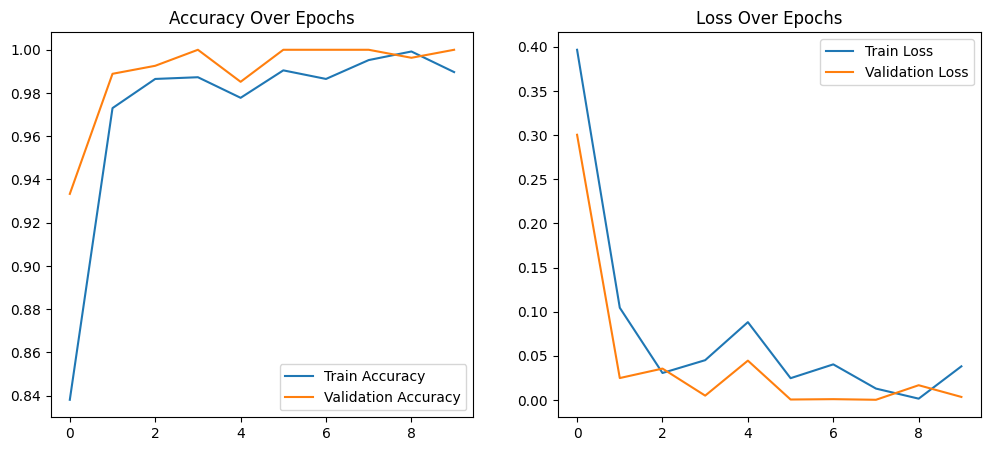

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()


Confusion Matrix & Metrics (on Test Set)

Precision: 1.0
Recall (Sensitivity): 1.0
F1-score: 1.0
Specificity per class: [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


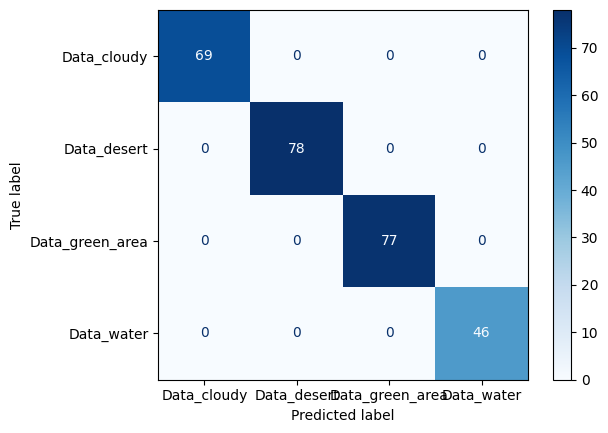

In [10]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print("Precision:", report['weighted avg']['precision'])
print("Recall (Sensitivity):", report['weighted avg']['recall'])
print("F1-score:", report['weighted avg']['f1-score'])

# Specificity calculation
specificity = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))
print("Specificity per class:", specificity)


Part 2: Swin Transformer Setup & Training

In [12]:
import timm
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset path (adjust if needed)
data_dir = '/content/Dataset/DataSet'

# Define data transforms (same as ConvNeXt)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load dataset and split
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


Load and Train Swin Transformer

In [13]:
# Load pretrained Swin Transformer (Tiny version)
model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=4)
model.to(device)

# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
train_acc, val_acc, train_loss, val_loss = [], [], [], []

for epoch in range(10):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc.append(correct / total)
    train_loss.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    correct, total, val_loss_epoch = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss_epoch += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc.append(correct / total)
    val_loss.append(val_loss_epoch / len(val_loader))

    print(f"Epoch {epoch+1}: Train Acc: {train_acc[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Epoch 1: Train Acc: 0.9437, Val Acc: 0.9778
Epoch 2: Train Acc: 0.9841, Val Acc: 0.9778
Epoch 3: Train Acc: 0.9889, Val Acc: 0.9852
Epoch 4: Train Acc: 0.9825, Val Acc: 0.9963
Epoch 5: Train Acc: 0.9984, Val Acc: 1.0000
Epoch 6: Train Acc: 0.9992, Val Acc: 0.9963
Epoch 7: Train Acc: 0.9976, Val Acc: 1.0000
Epoch 8: Train Acc: 0.9984, Val Acc: 1.0000
Epoch 9: Train Acc: 1.0000, Val Acc: 1.0000
Epoch 10: Train Acc: 1.0000, Val Acc: 1.0000


Accuracy & Loss Visualization

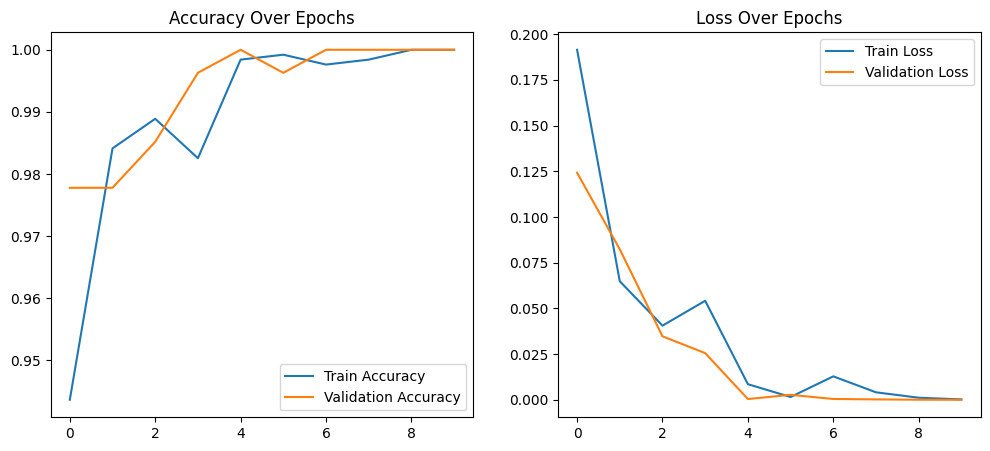

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()
plt.title("Accuracy Over Epochs")

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title("Loss Over Epochs")

plt.show()

Evaluation on Test Set

Precision: 1.0
Recall (Sensitivity): 1.0
F1-score: 1.0
Specificity per class: [np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0)]


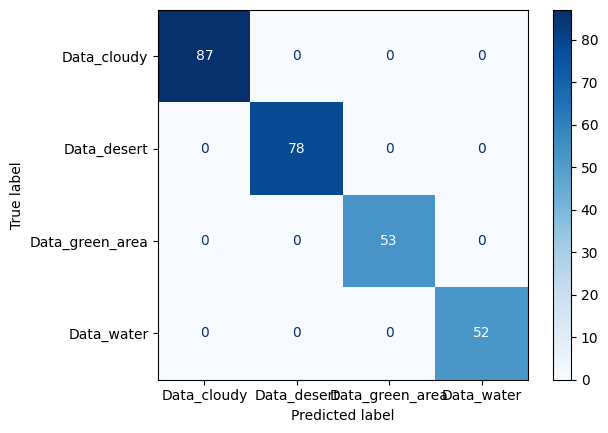

In [15]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print("Precision:", report['weighted avg']['precision'])
print("Recall (Sensitivity):", report['weighted avg']['recall'])
print("F1-score:", report['weighted avg']['f1-score'])

# Specificity per class
specificity = []
for i in range(len(cm)):
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    fp = cm[:, i].sum() - cm[i, i]
    specificity.append(tn / (tn + fp))
print("Specificity per class:", specificity)
